In [1]:
# Install depedency
!pip install -q skorch
!pip install -q scikit-learn

     |████████████████████████████████| 155 kB 29.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
%cd '/content/drive/MyDrive/code/'

/content/drive/MyDrive/code


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import skorch
from skorch.callbacks import EpochScoring
from skorch.classifier import NeuralNetClassifier

import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torch.optim import Adam, SGD
from torch.nn import ReLU, Sigmoid, Tanh, Softmax, CrossEntropyLoss
from torch.nn import Module, Sequential, Conv2d, MaxPool2d, Flatten, Linear

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-darkgrid')

torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using {} device\n'.format(device))

print("Skorch Version       : {}".format(skorch.__version__))
print("Scikit-Learn Version : {}".format(sklearn.__version__))
print("Pytorch Version      : {}".format(torch.__version__))

Using cpu device

Skorch Version       : 0.11.0
Scikit-Learn Version : 1.0.2
Pytorch Version      : 1.11.0+cu113


In [6]:
def data_preparation(base_path, csv_filename, test_ratio=0.2):
    df = pd.read_csv(csv_filename, usecols=['classname', 'img'])
    df = df[df['classname'].isin(['c0','c1','c2','c3','c4'])].reset_index(drop=True)
    
    train_set, test_set = train_test_split(df, test_size=test_ratio, stratify=df[['classname']], random_state=123)
    
    print("{:<18}: {} sample".format("Total samples", len(df)))
    print("{:<18}: {} sample".format("Train samples", len(train_set)))
    print("{:<18}: {} sample".format("Test samples", len(test_set)))
    
    return train_set, test_set


def data_preprocessing(base_path, df, size:list, prefix='train'):
    images = []
    for path in df.values:
        image = Image.open(f"{base_path + path[0]}/{path[1]}")
        image = image.resize(tuple(size))
        image = np.array(image).astype('float32')
        images.append(image)
    
    X = np.array(images) / 255.0
    X = X.reshape(X.shape[0], 3, size[0], size[1]).astype(np.float32)
    y = np.asarray(df['classname'].str.extract('(\d+)', expand=False), dtype=np.int64)
    
    print(f"{prefix} images resized to {size}")
    
    return X, y

In [7]:
class ConvNeuralNet(Module):
    def __init__(self, hidden, act='relu'):
        super().__init__()
        self.conv1 = Conv2d(in_channels=3,
                            out_channels=4,
                            kernel_size=(3, 3),
                            bias=False)
        
        self.conv2 = Conv2d(in_channels=4,
                        out_channels=3,
                        kernel_size=(3, 3),
                        bias=False)
        
        self.pool = MaxPool2d(2, 2)
        
        self.fc1 = Linear(in_features=3 * 30 * 30,
                          out_features=hidden,
                          bias=False)
        
        self.fc2 = Linear(in_features=hidden,
                          out_features=5,
                          bias=False)
        
        self.softmax = Softmax(dim=1)
        
        
        if act=='sigmoid':
            self.act = Sigmoid()
        elif act=='tanh':
            self.act = Tanh()
        else:
            self.act = ReLU()
    

    def forward(self, x_input):
        x = self.act(self.conv1(x_input))
        x = self.act(self.conv2(x))
        x = self.pool(x)
        x = self.act(self.fc1(torch.flatten(x, start_dim=1)))
        x = self.softmax(self.fc2(x))

        return x

In [8]:
imgs_path = f'imgs_dataset/'
csv_file = 'driver_imgs_list.csv'
img_size = [64, 64]
test_ratio = 0.1
k = 5

In [9]:
train_df, test_df = data_preparation(imgs_path, csv_file, test_ratio)

Total samples     : 11745 sample
Train samples     : 10570 sample
Test samples      : 1175 sample


In [10]:
x_train, y_train = data_preprocessing(imgs_path, train_df, img_size, prefix='train')
x_test, y_test = data_preprocessing(imgs_path, test_df, img_size, prefix='test')

train images resized to [64, 64]
test images resized to [64, 64]


In [11]:
model = NeuralNetClassifier(ConvNeuralNet,
                            lr=0.001,
                            module__hidden=32,
                            module__act='tanh',
                            batch_size=16,
                            max_epochs=50,
                            optimizer=Adam,
                            criterion=CrossEntropyLoss,
                            iterator_train__shuffle=True,
                            callbacks=[EpochScoring(scoring='accuracy', on_train=True, lower_is_better=False)],
                            verbose=1,
                            device=device)

In [12]:
scores = cross_validate(model, 
                        x_train, 
                        y_train, 
                        scoring='accuracy', 
                        cv=k, 
                        return_train_score=True, 
                        verbose=0)

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.6507        1.2900       0.8836        1.0513  6.4742
      2      0.9171        1.0109       0.9350        0.9812  6.2929
      3      0.9488        0.9681       0.9456        0.9701  6.2988
      4      0.9633        0.9489       0.9610        0.9495  6.2095
      5      0.9713        0.9394       0.9645        0.9500  6.2617
      6      0.9752        0.9330       0.9675        0.9415  6.2832
      7      0.9792        0.9285       0.9722        0.9375  6.3188
      8      0.9772        0.9332       0.9687        0.9444  6.3166
      9      0.9787        0.9305       0.9716        0.9399  6.2957
     10      0.9830        0.9250       0.9746        0.9340  6.3099
     11      0.9865        0.9205       0.9775        0.9307  6.2819
     12      0.9877        0.9182       0.9787        0.9278  6.2551
     13      0.9874        0.9176 

In [13]:
scores

{'fit_time': array([316.46087599, 312.45115447, 318.784271  , 317.16119242,
        317.67073298]),
 'score_time': array([0.81932116, 0.82880926, 0.82282376, 0.82021451, 0.83648944]),
 'test_score': array([0.9782403 , 0.99195837, 0.9820246 , 0.97209082, 0.99385052]),
 'train_score': array([0.98758278, 0.9973983 , 0.98663671, 0.98545412, 0.99810785])}

In [14]:
print('mean train acc : ', scores['train_score'].sum()/k)
print('mean test acc  : ', scores['test_score'].sum()/k)
print('mean fit time  : ', scores['fit_time'].sum()/k)

mean train acc :  0.9910359508041626
mean test acc  :  0.9836329233680227
mean fit time  :  316.5056453704834


In [15]:
model.fit(x_train, y_train)

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.7084        1.2329       0.8997        1.0273  7.8361
      2      0.9462        0.9740       0.9565        0.9594  7.7190
      3      0.9750        0.9380       0.9716        0.9379  7.7699
      4      0.9843        0.9251       0.9778        0.9315  7.8105
      5      0.9885        0.9201       0.9749        0.9333  7.7844
      6      0.9916        0.9173       0.9801        0.9277  7.7274
      7      0.9942        0.9127       0.9801        0.9276  7.8022
      8      0.9940        0.9135       0.9830        0.9260  7.7852
      9      0.9954        0.9111       0.9834        0.9218  7.7514
     10      0.9961        0.9102       0.9801        0.9287  7.7456
     11      0.9947        0.9135       0.9882        0.9204  7.7653
     12      0.9950        0.9130       0.9830        0.9237  7.8097
     13      0.9973        0.9092 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvNeuralNet(
    (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (conv2): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=2700, out_features=32, bias=False)
    (fc2): Linear(in_features=32, out_features=5, bias=False)
    (softmax): Softmax(dim=1)
    (act): Tanh()
  ),
)

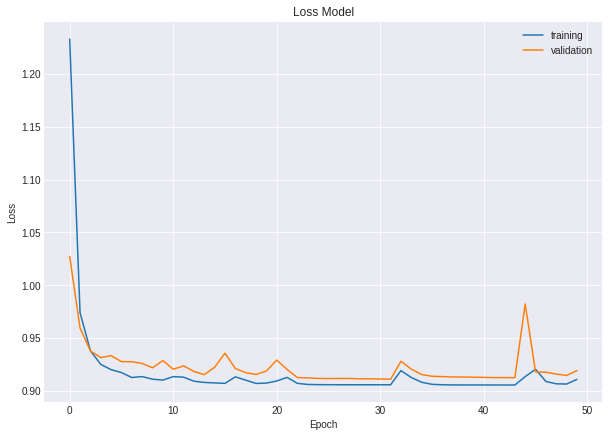

In [16]:
train_loss = model.history[:, 'train_loss']
valid_loss = model.history[:, 'valid_loss']

plt.figure(figsize=(10,7))
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

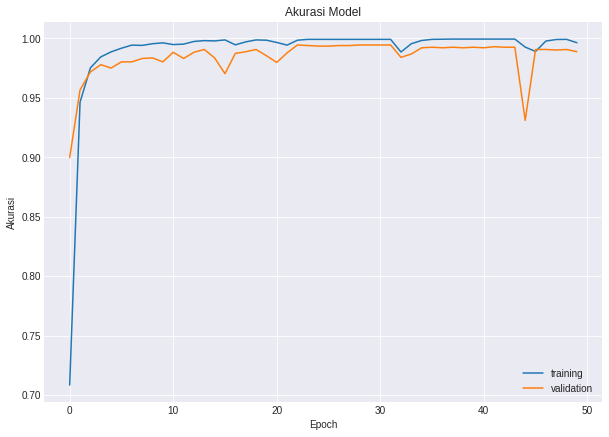

In [17]:
train_acc = model.history[:, 'accuracy']
valid_acc = model.history[:, 'valid_acc']

plt.figure(figsize=(10, 7))
plt.plot(train_acc, label='training')
plt.plot(valid_acc, label='validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')
plt.show()

In [18]:
y_pred = model.predict(x_test)

In [19]:
test_acc = accuracy_score(y_test, y_pred)

print(f'Akurasi model pada data uji adalah {test_acc} persen')

Akurasi model pada data uji adalah 0.985531914893617 persen


In [20]:
target_names = ['Safe driving','Texting-right','Talking on the phone-right','Texting-left','Talking on the phone-left']

print(classification_report(y_test, y_pred, target_names=target_names))

                            precision    recall  f1-score   support

              Safe driving       0.98      0.98      0.98       249
             Texting-right       0.97      1.00      0.98       227
Talking on the phone-right       0.99      0.99      0.99       232
              Texting-left       0.99      0.98      0.99       235
 Talking on the phone-left       0.99      0.99      0.99       232

                  accuracy                           0.99      1175
                 macro avg       0.99      0.99      0.99      1175
              weighted avg       0.99      0.99      0.99      1175



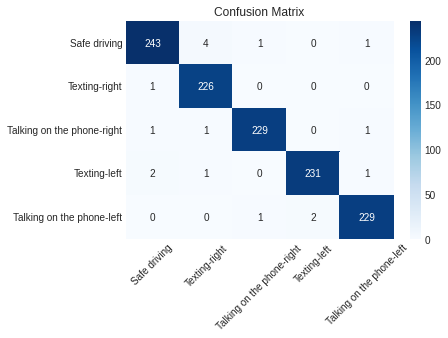

In [21]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                     index=target_names,
                     columns=target_names)

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [22]:
mispred_df = test_df
mispred_df['y_test'] = y_test
mispred_df['y_pred'] = y_pred

mispred_df = mispred_df[mispred_df['y_test'] != mispred_df['y_pred']]

print(f"Jumlah data yang misklasifikasi sebanyak {len(mispred_df)} dari {len(test_df)}")

Jumlah data yang misklasifikasi sebanyak 17 dari 1175


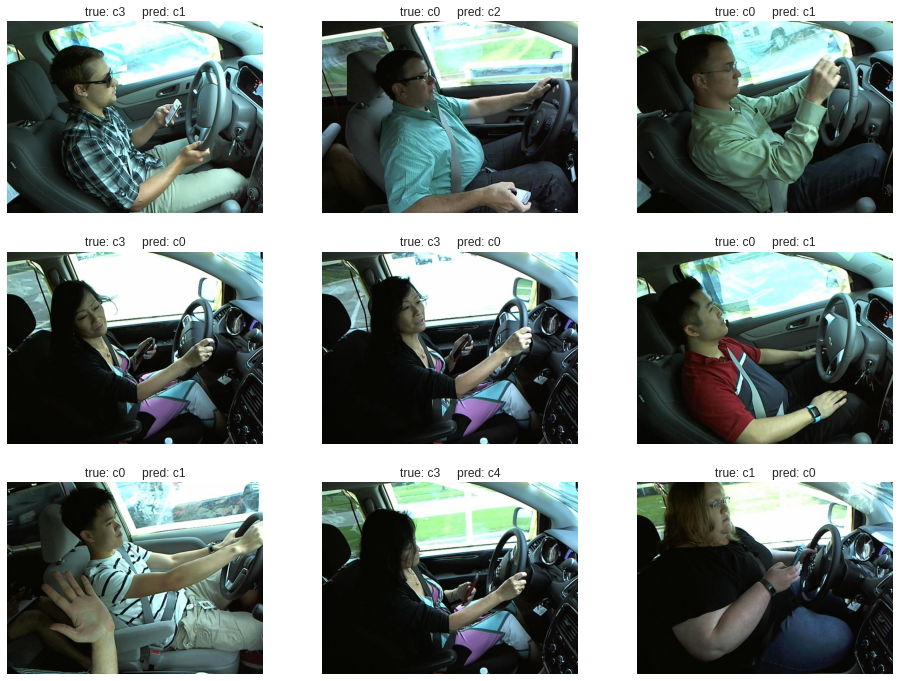

In [23]:
plt.figure(figsize=(16, 12))
num_samples = 9 if len(mispred_df) >=  9 else len(mispred_df)
for i, rows in mispred_df.sample(num_samples).reset_index(drop=True).iterrows():
    plt.subplot(330 + 1 + i)
    img = plt.imread(f"{imgs_path + rows['classname']}/{rows['img']}")
    plt.title(f"true: c{rows['y_test']}     pred: c{rows['y_pred']}")
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

plt.show()



---



In [ ]:
import pickle
from datetime import datetime

now = datetime.now()
now = now.strftime('%Y-%m-%d_%H-%M-%S')

# saving model
with open('model/save_driving_demo_'+now+'.pkl', 'wb') as f:
    pickle.dump(model, f)